## About the CIFAR-10 dataset

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (classification of small images across 10 distinct classes---airplane, automobile, bird, cat, deer, dog, frog, horse, ship & truck).


![](cifar_10.png)

The CIFAR-10 dataset contains 50000 training examples and 10000 test examples. Each example is a $32 \times 32 \times 32$ pixels coloured image.

## Loading and pre-processing CIFAR-10 dataset



(50000, 32, 32, 3)
(10000, 32, 32, 3)


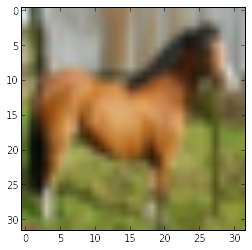

horse


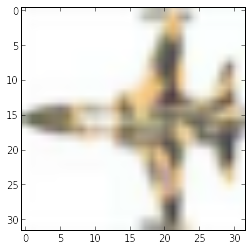

plane


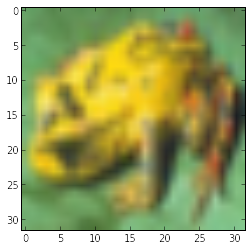

frog
(50000, 3072)
(10000, 3072)
[[ 0.99215686  0.99215686  0.99215686 ...,  0.98431373  0.98431373
   0.98431373]
 [ 0.40000001  0.63137257  0.40000001 ...,  0.51764709  0.78431374
   0.56078434]
 [ 0.38039216  0.60784316  0.43137255 ...,  0.3019608   0.54509807
   0.40000001]
 [ 0.0627451   0.05490196  0.03137255 ...,  0.17647059  0.25490198
   0.56862748]]


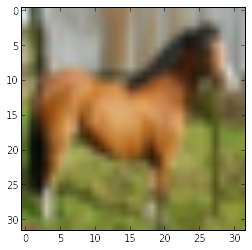

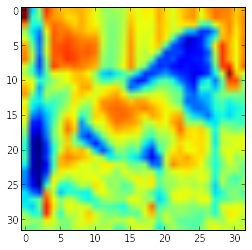

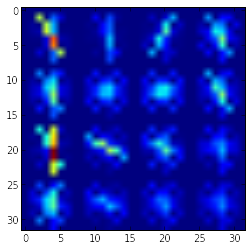

In [4]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import itertools
import os
os.environ['KERAS_BACKEND']="theano"

from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from sklearn.utils import shuffle
from skimage import feature
from skimage import data

(X_train_img, y_train), (X_test_img, y_test) = cifar10.load_data() # fetch CIFAR-10 data # dirname="."??
print(X_train_img.shape)
print(X_test_img.shape)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Shuffle examples
X_train_img, y_train = shuffle(X_train_img, y_train)
X_test_img, y_test = shuffle(X_test_img, y_test)

plt.figure()
plt.imshow(X_train_img[0])
plt.show()
print(class_names[int(y_train[0])])
plt.figure()
plt.imshow(X_train_img[1])
plt.show()
print(class_names[int(y_train[1])])
plt.figure()
plt.imshow(X_train_img[2])
plt.show()
print(class_names[int(y_train[2])])

num_train, depth, height, width = X_train_img.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test_img.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

# Produce a [0;1] normalized "image" for potential input into a convNet
X_train_img_norm = X_train_img.astype('float32') 
X_test_img_norm = X_test_img.astype('float32')
X_train_img_norm /= np.max(X_train_img_norm) # Normalise data to [0, 1] range
X_test_img_norm /= np.max(X_test_img_norm) # Normalise data to [0, 1] range

# Rasterize normalized images into 1D vectors for potential input of raw image into standard ML algo such as kNN, MLP, SVM, etc
X_train_vectNorm = X_train_img_norm.reshape(num_train,height*width*depth)
X_test_vectNorm = X_test_img_norm.reshape(num_test,height*width*depth)

print(X_train_vectNorm.shape)
print(X_test_vectNorm.shape)
print(X_train_vectNorm[1:5])

######################################################
# Compute HOG feature as potential BETTER input into standard ML algo such as kNN, MLP, SVM, etc
from skimage import color

# test sur la 1ère image :
image0 = X_train_img[0]
image0_luminance = color.rgb2gray(image0) ## Il faut supprimer une dimension : on utilise la luminance plutôt que le RGB
plt.figure()
plt.imshow(image0)
plt.show()
plt.figure()
plt.imshow(image0_luminance)
plt.show()
hog0, hog_image0 = feature.hog(color.rgb2gray(image0_luminance), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
plt.figure()
plt.imshow(hog_image0)
plt.show()

# transformation des images en descripteurs HOG :
XHog_train_img = []
for img in X_train_img :
    hog, hog_image = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
    XHog_train_img.append(hog)
XHog_test_img = []
for img in X_test_img :
    hog, hog_image = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
    XHog_test_img.append(hog)

# Normalisation :
XHog_train_img_norm = np.array(XHog_train_img).astype('float32')
XHog_test_img_norm = np.array(XHog_test_img).astype('float32')
XHog_train_img_norm /= np.max(XHog_train_img_norm) # Normalise data to [0, 1] range
XHog_test_img_norm /= np.max(XHog_test_img_norm) # Normalise data to [0, 1] range


# Une fonction pour afficher graphiquement les matrices de confusion

## Baseline method: kNN on raw normalized pixels

In [5]:
#%matplotlib inline
import matplotlib.pyplot as plt
import itertools

# Definition for the function that plot the confusion matrix
# See : http://www.sci-kit.org/
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

clf = neighbors.KNeighborsClassifier(n_neighbors=5)
print(y_train.shape)
clf.fit(X_train_vectNorm[:30000], y_train.ravel()[:30000]) # utiliser toutes les données conduit à une Memory Error

y_test_pred_knn = clf.predict(X_test_vectNorm)


cnf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)
print(cnf_matrix_knn)

np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_knn, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

(50000, 1)


### Remarques sur les résultats :

La matrice de confusion est très mauvaise : toutes les images sont vues comme appartenant à la première classe. Comparer les pixels des images n'est pas une méthode très pertinente pour classifier les images. Par ailleurs, l'algorithme des plus proches voisins est très lent à s'exécuter, et utilise beaucoup de mémoire : nous avons dû limiter la taille du jeu d'entraînement pour ne pas avoir d'erreur de mémoire. En raison de ce temps d'exécution, nous n'avons testé qu'une valeur du nombre de voisins : 5.

## Random Forests on raw normalized pixels

n_estimators= 10  max_depth= None max_features= auto
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (on test set) =  0.0992
             precision    recall  f1-score   support

      plane       0.06      0.01      0.01      1000
        car       0.00      0.00      0.00      1000
       bird       0.10      0.98      0.18      1000
        cat       0.18      0.00      0.01      1000
       deer       0.00      0.00      0.00      1000
        dog       0.00      0.00      0.00      1000
       frog       0.00      0.00      0.00      1000
      horse       0.00      0.00      0.00      1000
       ship  

/home/lmeyrat/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.97  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]]


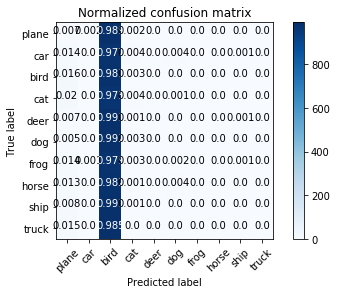

In [9]:
#Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(X_train_vectNorm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(X_test_vectNorm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(X_test_vectNorm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## Random forests on HOG descriptors

('n_estimators=', 10, ' max_depth=', None, 'max_features=', 'auto')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('Accuracy (on test set) = ', 0.34539999999999998)
             precision    recall  f1-score   support

      plane       0.39      0.50      0.44      1000
        car       0.43      0.47      0.45      1000
       bird       0.23      0.29      0.26      1000
        cat       0.18      0.19      0.18      1000
       deer       0.31      0.44      0.37      1000
        dog       0.30      0.24      0.27      1000
       frog       0.41      0.39      0.40      1000
      horse       0.39      0.27 

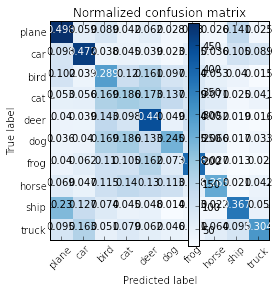

In [8]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(XHog_train_img_norm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(XHog_test_img_norm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(XHog_test_img_norm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# MLP classifier

## Training

In [49]:
import os
os.environ['KERAS_BACKEND']="tensorflow"
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(42, input_dim=32*32*3))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_vectNorm, Y_train, epochs=20, batch_size=32)




Epoch 1/20
50000/50000 [==============================] - 4s - loss: 1.9321 - acc: 0.3063     
Epoch 2/20
50000/50000 [==============================] - 4s - loss: 1.7810 - acc: 0.3641     
Epoch 3/20
50000/50000 [==============================] - 4s - loss: 1.7172 - acc: 0.3901     
Epoch 4/20
50000/50000 [==============================] - 4s - loss: 1.6759 - acc: 0.4051     
Epoch 5/20
50000/50000 [==============================] - 4s - loss: 1.6435 - acc: 0.4180     
Epoch 6/20
50000/50000 [==============================] - 4s - loss: 1.6205 - acc: 0.4263     
Epoch 7/20
50000/50000 [==============================] - 4s - loss: 1.6036 - acc: 0.4322     
Epoch 8/20
50000/50000 [==============================] - 4s - loss: 1.5861 - acc: 0.4373     
Epoch 9/20
50000/50000 [==============================] - 4s - loss: 1.5785 - acc: 0.4406     
Epoch 10/20
50000/50000 [==============================] - 4s - loss: 1.5718 - acc: 0.4417     
Epoch 11/20
50000/50000 [========================

### display confusion matrix MLP

[[648  21 125   6  44   6   9  13  98  30]
 [ 83 496  47   8  24   7  27  19  89 200]
 [112  18 457  28 204  49  65  32  17  18]
 [ 58  17 249 145 119 145 145  34  33  55]
 [ 96   4 220  19 501  19  64  36  23  18]
 [ 37  19 249  94 134 254  90  57  28  38]
 [ 19   8 143  32 227  33 481  18  15  24]
 [ 79  20 173  14 168  49  28 410  10  49]
 [228  53  51  10  40   9  10   9 543  47]
 [113 120  47  14  23  19  44  29  82 509]]
Normalized confusion matrix
[[ 0.65  0.02  0.12  0.01  0.04  0.01  0.01  0.01  0.1   0.03]
 [ 0.08  0.5   0.05  0.01  0.02  0.01  0.03  0.02  0.09  0.2 ]
 [ 0.11  0.02  0.46  0.03  0.2   0.05  0.07  0.03  0.02  0.02]
 [ 0.06  0.02  0.25  0.14  0.12  0.14  0.14  0.03  0.03  0.06]
 [ 0.1   0.    0.22  0.02  0.5   0.02  0.06  0.04  0.02  0.02]
 [ 0.04  0.02  0.25  0.09  0.13  0.25  0.09  0.06  0.03  0.04]
 [ 0.02  0.01  0.14  0.03  0.23  0.03  0.48  0.02  0.01  0.02]
 [ 0.08  0.02  0.17  0.01  0.17  0.05  0.03  0.41  0.01  0.05]
 [ 0.23  0.05  0.05  0.01  0.04  0.01

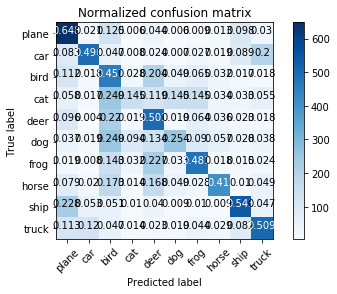

In [43]:
from sklearn.metrics import confusion_matrix

y_test_pred_mlp = model.predict(X_test_vectNorm)
Y_test_pred_mlp = np.argmax(y_test_pred_mlp, 1)

cnf_matrix_mlp = confusion_matrix(y_test, Y_test_pred_mlp)
print(cnf_matrix_mlp)
np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_mlp, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Test on single examples

(1, 3072)


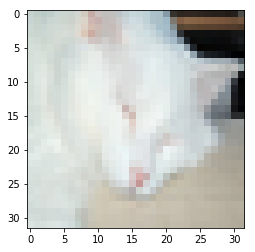

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Prediction :  bird
Verité :  cat


In [48]:
def test_exemple(n):
    test = np.array([X_test_vectNorm[n]])
    print(test.shape)
    predict = model.predict_on_batch(test)
    plt.figure()
    plt.imshow(X_test_img[n])
    plt.show()
    print(predict)
    print("Prediction : ", class_names[np.argmax(predict)])
    print("Verité : ", class_names[int(y_test[n])])
    
test_exemple(30)
    